In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import seaborn as sns
#from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('purchase_data.csv')
# Split into training and test sets
#data, data_test = train_test_split(data_total, test_size=0.2, random_state=42, stratify=data_total['Customer ID'])

In [3]:
# Creates the features to be analyzed by K-Means

customer_spending = data.groupby('Customer ID').agg({
    'Purchase Amount': ['sum', 'count'],
    'Product ID': pd.Series.nunique
}).reset_index()
customer_spending.columns = ['Customer ID', 'TotalSpending', 'PurchaseFrequency', 'UniqueProducts']

scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customer_spending[['TotalSpending', 'PurchaseFrequency', 'UniqueProducts']])

kmeans = KMeans(n_clusters=3, random_state=42)
customer_spending['Cluster'] = kmeans.fit_predict(customer_scaled)
customer_spending

,Customer ID,TotalSpending,PurchaseFrequency,UniqueProducts,Cluster
0,C001,846.08,11,10,2
1,C002,710.56,11,10,2
2,C003,934.36,9,9,2
3,C004,929.69,11,11,2
4,C005,792.25,10,10,2
...,...,...,...,...,...
495,C496,1480.85,13,12,1
496,C497,1749.34,14,11,1
497,C498,754.54,9,9,2
498,C499,1125.71,12,12,2


In [4]:
# # Reassign cluster labels based on logical trends
cluster_means = customer_spending.groupby('Cluster')[['TotalSpending', 'PurchaseFrequency']].mean()
sorted_clusters = cluster_means.sort_values(by=['TotalSpending', 'PurchaseFrequency'], ascending=[False, True]).index.tolist()
cluster_labels = {sorted_clusters[0]: "High Spenders", sorted_clusters[1]: "Frequent Shoppers", sorted_clusters[2]: "Occasional Buyers"}
customer_spending['ClusterLabel'] = customer_spending['Cluster'].map(cluster_labels)


In [5]:
data = data.merge(customer_spending[['Customer ID', 'Cluster', 'ClusterLabel']], on='Customer ID', how='left')

## These are the clusters that were formed using K-means.

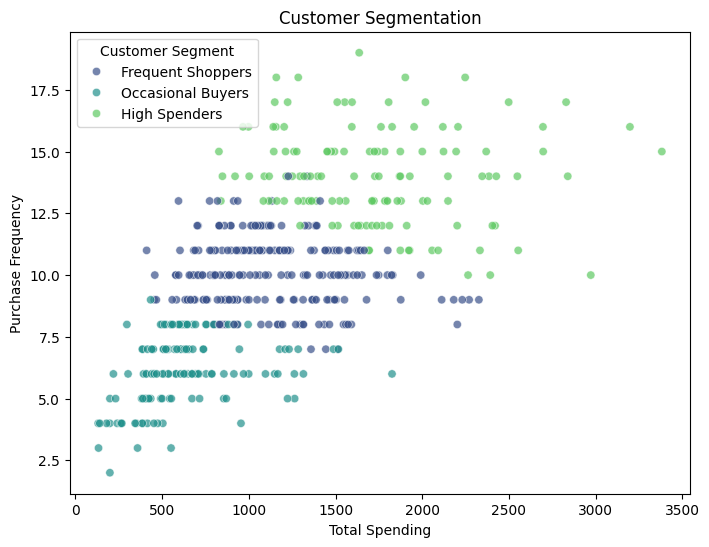

In [6]:
# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=customer_spending['TotalSpending'],
    y=customer_spending['PurchaseFrequency'],
    hue=customer_spending['ClusterLabel'],
    palette='viridis', alpha=0.7
)

plt.xlabel('Total Spending')
plt.ylabel('Purchase Frequency')
plt.title('Customer Segmentation')
plt.legend(title='Customer Segment')
plt.show()

# This is the Recommendation algorithm:

In [12]:
# Step 3: Product Recommendation using Cosine Similarity with Clusters
from sklearn.metrics.pairwise import cosine_similarity

# Create a customer-product matrix
customer_features = data.pivot_table(index='Customer ID',
                                     columns='Product ID',
                                     values='Purchase Amount',
                                     fill_value=0)
customer_features['Cluster'] = customer_spending.set_index('Customer ID')['Cluster']

# Normalize data before similarity calculation
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features)

# Compute cosine similarity
similarity_matrix = cosine_similarity(customer_features_scaled)
similarity_df = pd.DataFrame(similarity_matrix, index=customer_features.index, columns=customer_features.index)

# Recommendation for a specific customer
target_customer = np.random.choice(data['Customer ID'].unique())   # Change as needed
target_cluster = customer_features.loc[target_customer, 'Cluster']
target_cluster_label = cluster_labels[target_cluster]

# Find similar customers within the same cluster
cluster_customers = customer_features[customer_features['Cluster'] == target_cluster].index
similar_customers = similarity_df.loc[target_customer, cluster_customers].sort_values(ascending=False)[1:4]

target_products = set(data[data['Customer ID'] == target_customer]['Product ID'])
recommendations = []

# Determine popular product categories in the cluster
category_counts = data[data['Customer ID'].isin(similar_customers.index)]['Product Category'].value_counts()
top_categories = category_counts.index[:3]  # Prioritize top 2 categories

min_recs = 5
for cust_id in similar_customers.index:
    customer_products = data[data['Customer ID'] == cust_id][['Product ID', 'Product Category']]

    # Get products from top categories with higher weight
    top_category_products = set(customer_products[customer_products['Product Category'].isin(top_categories)]['Product ID'])
    new_recs_top = top_category_products - target_products
    recommendations.extend(list(new_recs_top) * 2)  # Double weight for top categories

    # Also include other products
    all_products = set(customer_products['Product ID'])
    new_recs_other = all_products - top_category_products - target_products
    recommendations.extend(list(new_recs_other))

# If still don't have enough recommendations, add popular products from the same cluster
if len(set(recommendations)) < min_recs:
    cluster_product_counts = data[data['Customer ID'].isin(cluster_customers)]['Product ID'].value_counts()
    popular_cluster_products = [prod for prod in cluster_product_counts.index if prod not in target_products]
    recommendations.extend(popular_cluster_products)

# If still don't have enough, add globally popular products
if len(set(recommendations)) < min_recs:
    global_product_counts = data['Product ID'].value_counts()
    popular_global_products = [prod for prod in global_product_counts.index if prod not in target_products]
    recommendations.extend(popular_global_products)

# Get unique recommendations and take top min_recs
recommended_products = list(dict.fromkeys(recommendations))[:min_recs]

# Output results
print(f"Customer {target_customer} belongs to segment {target_cluster}")
print(f"Recommended products for Customer {target_customer}: {recommended_products}")

Customer C451 belongs to segment 0
Recommended products for Customer C451: ['P008', 'P004', 'P047', 'P014', 'P020']


In [8]:
def get_cluster_analysis():
  '''
  Returns the most popular product category in each cluster.
  '''
  # Group by cluster and count product categories
  cluster_popular_categories = data.groupby('Cluster')['Product Category'].agg(lambda x: x.value_counts().index[0])
  return cluster_popular_categories

def get_similar_customer_purchases(similar_customers):
  '''
  Returns the products purchased by similar customers.
  '''
  similar_purchases = data[data['Customer ID'].isin(similar_customers.index)][['Customer ID', 'Product ID', 'Product Category']]
  return similar_purchases


In [9]:
# Visualization: Recommended products vs. Popular categories
def plot_recommendation_vs_cluster(target_cluster, recommended_products):
  '''
  Plots the categories of the recommended products vs. the popular categories in the target cluster.
  '''
  # Get popular categories in the target cluster
  cluster_popular_categories = data[data['Cluster'] == target_cluster]['Product Category'].value_counts()

  plt.figure(figsize=(8, 5))
  sns.barplot(x=cluster_popular_categories.index, y=cluster_popular_categories.values, alpha=0.7, label='Popular Categories')

  recommended_categories = data[data['Product ID'].isin(recommended_products)]['Product Category'].value_counts()
  sns.barplot(x=recommended_categories.index, y=recommended_categories.values, alpha=0.7, color='red', label='Recommended')

  plt.xlabel('Product Category')
  plt.ylabel('Count')
  plt.title('Comparison: Recommended Products vs. Popular Cluster Categories')
  plt.legend()
  plt.show()

# Visualization: Similarity heatmap
def plot_similarity_heatmap(similarity_df, similar_customers):
  '''
  Plots a heatmap of similarity between target customer and similar customers.
  '''
  plt.figure(figsize=(8, 6))
  sns.heatmap(similarity_df.loc[[target_customer] + list(similar_customers.index), similar_customers.index], annot=True, cmap='coolwarm')
  plt.title('Similarity between Target Customer and Similar Customers')
  plt.xlabel('Similar Customers')
  plt.ylabel('Target Customer')
  plt.show()

Customer C451 belongs to segment Occasional Buyers
Recommended products for Customer C451: ['P008', 'P004', 'P047', 'P014', 'P020']
Popular product categories per cluster:
Cluster
0            Grocery
1            Grocery
2    Health & Beauty
Name: Product Category, dtype: object
Products purchased by similar customers:
     Customer ID Product ID Product Category
477         C092       P013  Health & Beauty
579         C466       P008  Health & Beauty
707         C092       P034         Clothing
882         C466       P023   Home & Kitchen
1133        C466       P034         Clothing
2520        C466       P016          Grocery
2752        C092       P014      Electronics
3066        C092       P004   Home & Kitchen
3080        C123       P023   Home & Kitchen
3487        C123       P016          Grocery
3504        C092       P047            Books
4121        C123       P020          Grocery
4567        C092       P010         Clothing


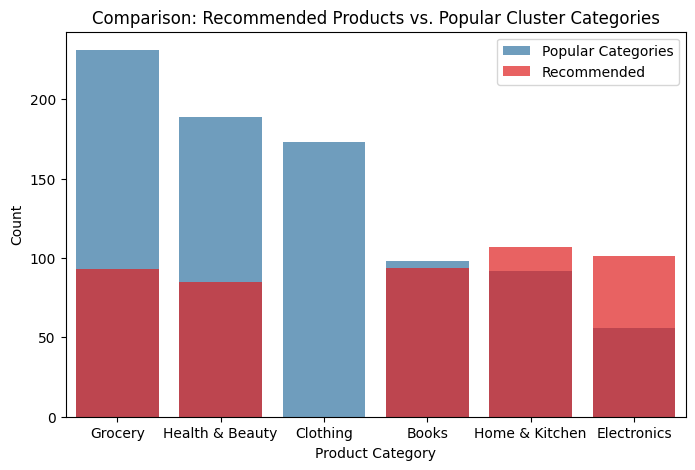

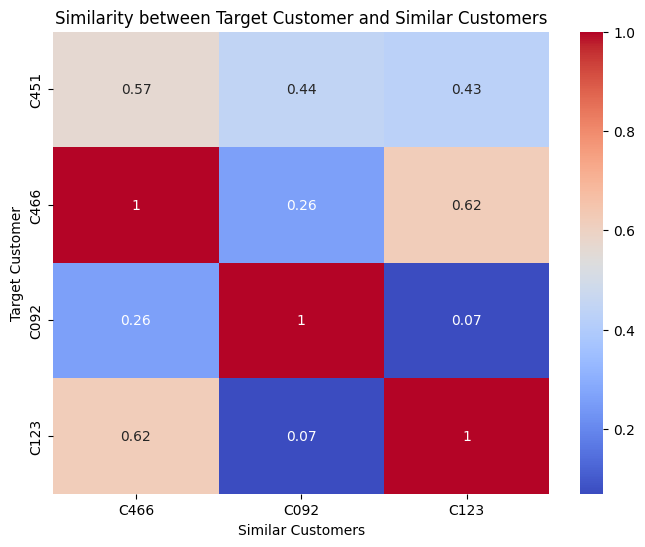

In [13]:
# Output results
print(f"Customer {target_customer} belongs to segment {target_cluster_label}")
print(f"Recommended products for Customer {target_customer}: {recommended_products}")
print("Popular product categories per cluster:")
print(get_cluster_analysis())
print("Products purchased by similar customers:")
print(get_similar_customer_purchases(similar_customers))

# Generate visualizations
plot_recommendation_vs_cluster(target_cluster, recommended_products)
plot_similarity_heatmap(similarity_df, similar_customers)

## The code below is to output the recommendations as a csv.

In [11]:
# #Creating a csv with all the customer recommendations:
# recommendation_df = pd.DataFrame(columns=["Customer ID", "RecommendedProducts"])

# # Iterate through all customers and generate recommendations
# for customer_id in customer_features.index:
#     target_customer = customer_id
#     target_cluster = customer_features.loc[target_customer, 'Cluster']

#     # Find similar customers within the same cluster
#     cluster_customers = customer_features[customer_features['Cluster'] == target_cluster].index
#     similar_customers = similarity_df.loc[target_customer, cluster_customers].sort_values(ascending=False)[1:4]

#     target_products = set(data[data['Customer ID'] == target_customer]['Product ID'])
#     recommendations = []

#     # Determine popular product categories in the cluster
#     category_counts = data[data['Customer ID'].isin(similar_customers.index)]['Product Category'].value_counts()
#     top_categories = category_counts.index[:3]  # Prioritize top 2 categories

#     category_weight = 1.5  # Increased weight for popular categories

#     # Loop through similar customers and recommend products from popular categories
#     # for cust_id in similar_customers.index:
#     #     customer_products = data[data['Customer ID'] == cust_id][['Product ID', 'Product Category']]
#     #     customer_products = customer_products[customer_products['Product Category'].isin(top_categories)]

#     #     products = set(customer_products['Product ID'])
#     #     new_recs = products - target_products
#     #     recommendations.extend(list(new_recs) * int(category_weight))  # Duplicate recommendations from popular categories

#     # # Get top N unique recommendations (limit to 5)
#     # recommended_products = list(set(recommendations))[:5]
#     min_recs = 5
#     for cust_id in similar_customers.index:
#         customer_products = data[data['Customer ID'] == cust_id][['Product ID', 'Product Category']]

#         # Get products from top categories with higher weight
#         top_category_products = set(customer_products[customer_products['Product Category'].isin(top_categories)]['Product ID'])
#         new_recs_top = top_category_products - target_products
#         recommendations.extend(list(new_recs_top) * 2)  # Double weight for top categories

#         # Also include other products
#         all_products = set(customer_products['Product ID'])
#         new_recs_other = all_products - top_category_products - target_products
#         recommendations.extend(list(new_recs_other))

#     # If still don't have enough recommendations, add popular products from the same cluster
#     if len(set(recommendations)) < min_recs:
#         cluster_product_counts = data[data['Customer ID'].isin(cluster_customers)]['Product ID'].value_counts()
#         popular_cluster_products = [prod for prod in cluster_product_counts.index if prod not in target_products]
#         recommendations.extend(popular_cluster_products)

#     # If still don't have enough, add globally popular products
#     if len(set(recommendations)) < min_recs:
#         global_product_counts = data['Product ID'].value_counts()
#         popular_global_products = [prod for prod in global_product_counts.index if prod not in target_products]
#         recommendations.extend(popular_global_products)

#     # Get unique recommendations and take top min_recs
#     recommended_products = list(dict.fromkeys(recommendations))[:min_recs]

#     # Append the recommendations for the customer
#     recommendation_df = recommendation_df._append({"Customer ID": target_customer, "RecommendedProducts": recommended_products}, ignore_index=True)

# # Save to CSV
# output_file = 'customer_recommendations.csv'
# recommendation_df.to_csv(output_file, index=False)

# output_file